
# Firewall Log Exploratory Data Analysis

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sympy.utilities.exceptions import ignore_warnings

pd.options.display.max_columns = 200
sns.set(style='whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Load Dataset
df = pd.read_csv(r"data/firewall_train.csv")
print("Loaded:", df.shape)
df.head()

Loaded: (10000, 15)


,Date,Time,Source,Source_port,Destination,Dest_Port,Protocol,Service,Policy_ID,State,Action,Duration,Bytes,Packets,Attack
0,2025-01-01,00:00:20,192.168.26.62,3106,140.23.152.109,27017,tcp,mongodb,POL-674,ESTABLISHED,allow,2.346,1074,2,benign
1,2025-01-01,00:00:26,192.168.71.56,46777,2.195.207.41,27017,tcp,mongodb,POL-204,SYN_ACK,allow,0.299,689,1,benign
2,2025-01-01,00:00:28,10.186.207.180,6188,32.250.237.97,110,tcp,pop3,POL-691,ESTABLISHED,allow,4.595,1651,1,benign
3,2025-01-01,00:00:34,10.218.246.27,42684,26.98.72.117,80,tcp,http,POL-373,ESTABLISHED,allow,1.814,1106,3,benign
4,2025-01-01,00:00:54,10.118.86.176,45890,164.177.143.57,6379,tcp,redis,POL-423,ESTABLISHED,allow,2.828,2054,7,benign


In [20]:
# Basic cleaning steps
# 1. Drop exact duplicates
dup_count = df.duplicated().sum()
print(f"Duplicate rows: {dup_count}")
df = df.drop_duplicates()

# 2. Coerce numeric columns
numeric_cols = ['Source_port','Dest_Port','Duration','Bytes','Packets']
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# 3. Parse Date+Time into datetime if possible
if 'Date' in df.columns and 'Time' in df.columns:
    combined = df['Date'].astype(str).str.strip() + ' ' + df['Time'].astype(str).str.strip()
    # try multiple formats with to_datetime (coerce errors)
    df['timestamp'] = pd.to_datetime(combined, errors='coerce', infer_datetime_format=True)
    print("Parsed timestamps:", df['timestamp'].notna().sum(), "non-null")
else:
    df['timestamp'] = pd.NaT

# 4. Missing value summary
missing = df.isna().sum().sort_values(ascending=False)
missing_percent = (df.isna().mean()*100).round(2).sort_values(ascending=False)
display(pd.concat([missing, missing_percent], axis=1, keys=['missing','missing_pct']).head(20))
df['timestamp'].head()


Duplicate rows: 0
Parsed timestamps: 10000 non-null


,missing,missing_pct
Date,0,0.0
Time,0,0.0
Source,0,0.0
Source_port,0,0.0
Destination,0,0.0
Dest_Port,0,0.0
Protocol,0,0.0
Service,0,0.0
Policy_ID,0,0.0
State,0,0.0


0   2025-01-01 00:00:20
1   2025-01-01 00:00:26
2   2025-01-01 00:00:28
3   2025-01-01 00:00:34
4   2025-01-01 00:00:54
Name: timestamp, dtype: datetime64[ns]

In [21]:
# Outlier detection using IQR for numeric columns
def detect_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((series < lower) | (series > upper)).sum()

outliers = {}
for c in numeric_cols:
    if c in df.columns:
        outliers[c] = int(detect_outliers_iqr(df[c].dropna()))
outliers

{'Source_port': 0,
 'Dest_Port': 849,
 'Duration': 477,
 'Bytes': 494,
 'Packets': 836}

In [ ]:
# Summary statistics
desc_num = df[numeric_cols].describe().T
desc_cat = df.select_dtypes(exclude='number').describe().T
desc_num, desc_cat.head(20)


## Static Plots

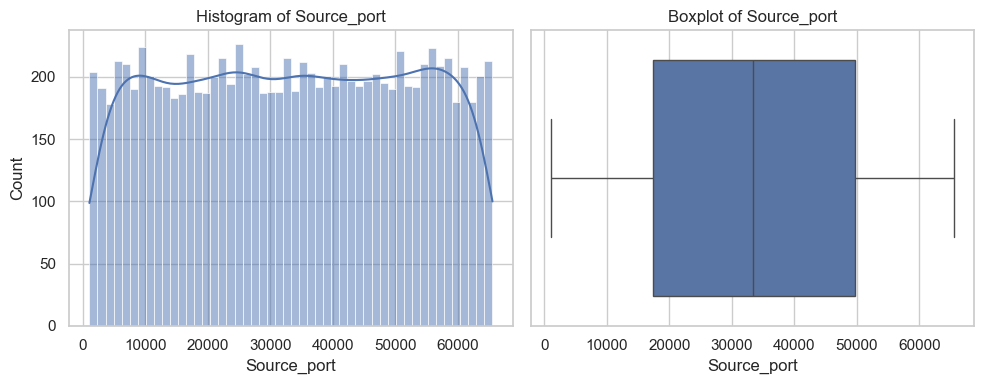

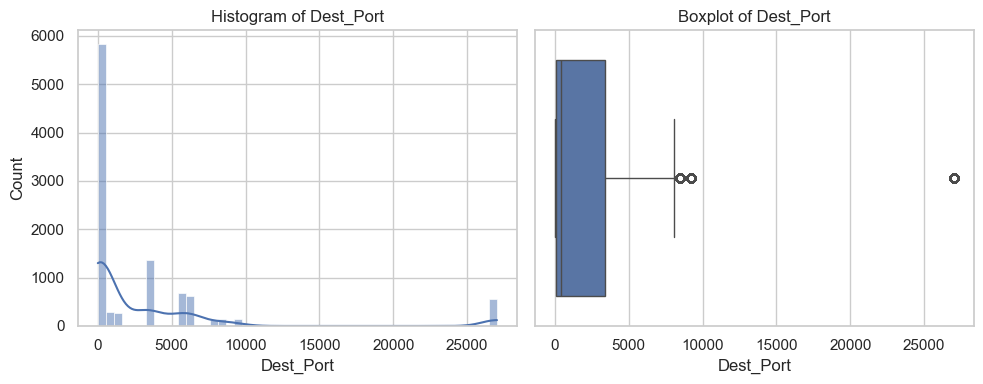

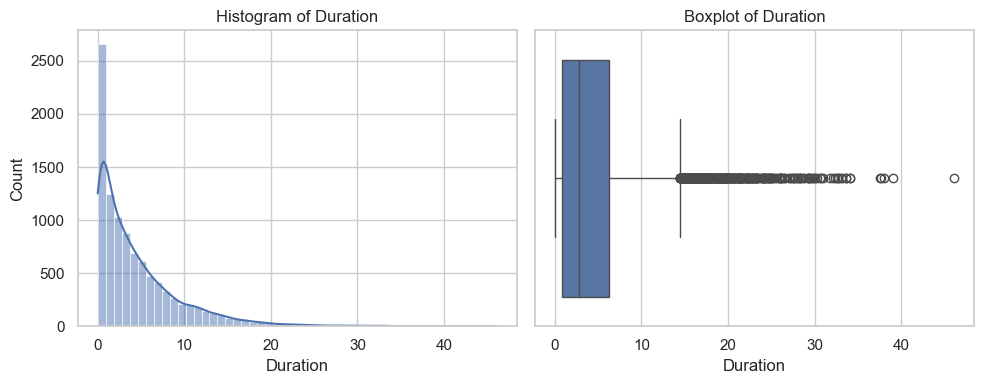

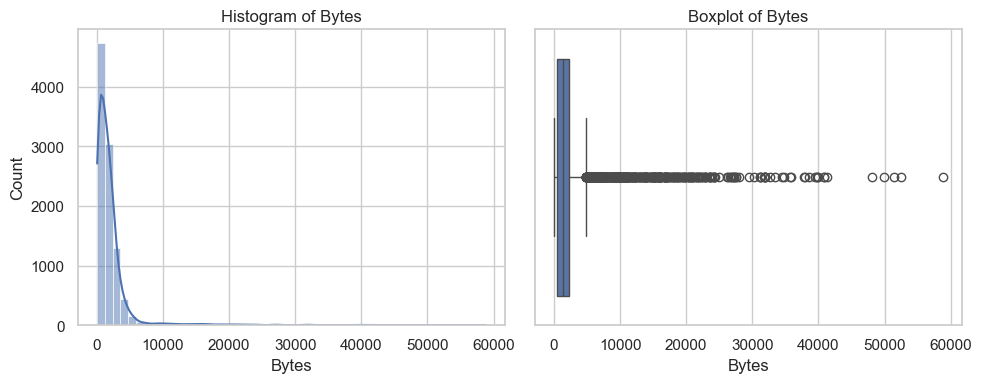

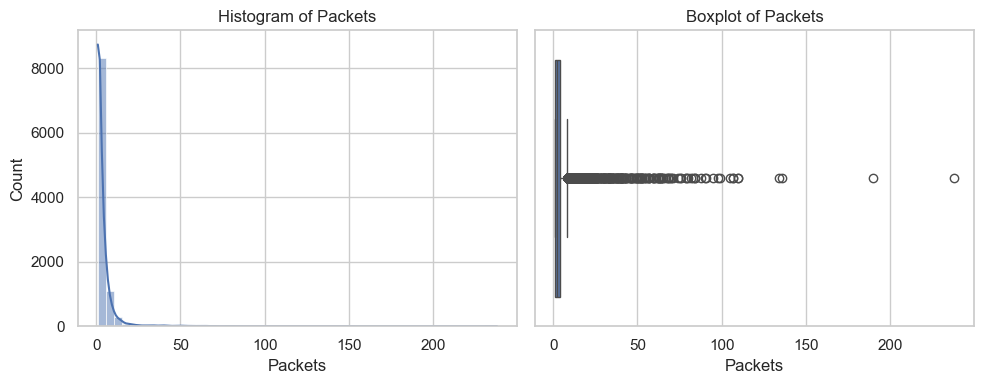

In [10]:

# Histogram and boxplot for numeric columns
num = [c for c in ['Source_port','Dest_Port','Duration','Bytes','Packets'] if c in df.columns]
for c in num:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(df[c].dropna(), kde=True, bins=50)
    plt.title(f"Histogram of {c}")
    plt.subplot(1,2,2)
    sns.boxplot(x=df[c].dropna())
    plt.title(f"Boxplot of {c}")
    plt.tight_layout()
    plt.show()


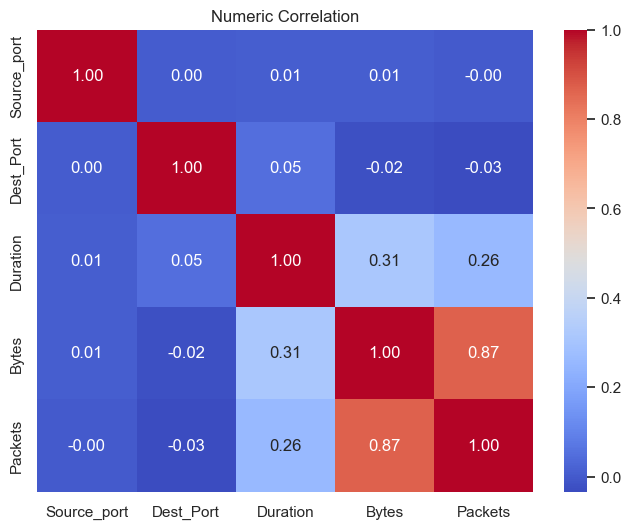

In [11]:

# Correlation heatmap (numeric)
if len(num)>1:
    plt.figure(figsize=(8,6))
    sns.heatmap(df[num].corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Numeric Correlation")
    plt.show()


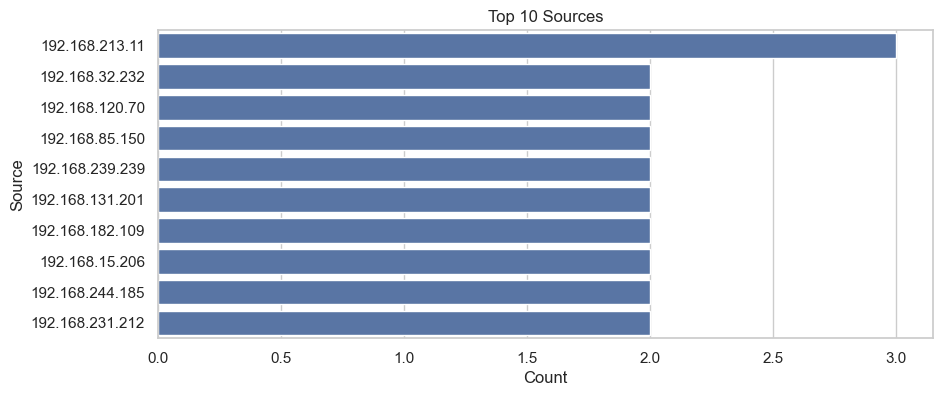

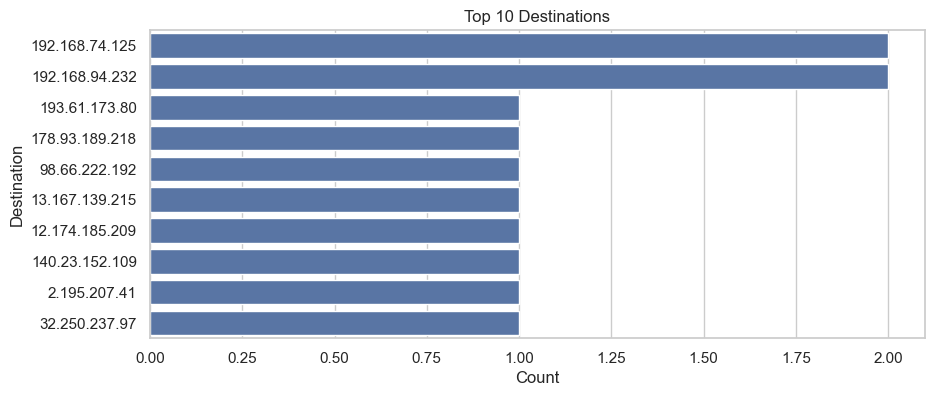

In [12]:

# Top sources and destinations
if 'Source' in df.columns:
    top_src = df['Source'].value_counts().head(10)
    plt.figure(figsize=(10,4))
    sns.barplot(x=top_src.values, y=top_src.index)
    plt.title('Top 10 Sources')
    plt.xlabel('Count')
    plt.show()
if 'Destination' in df.columns:
    top_dst = df['Destination'].value_counts().head(10)
    plt.figure(figsize=(10,4))
    sns.barplot(x=top_dst.values, y=top_dst.index)
    plt.title('Top 10 Destinations')
    plt.xlabel('Count')
    plt.show()


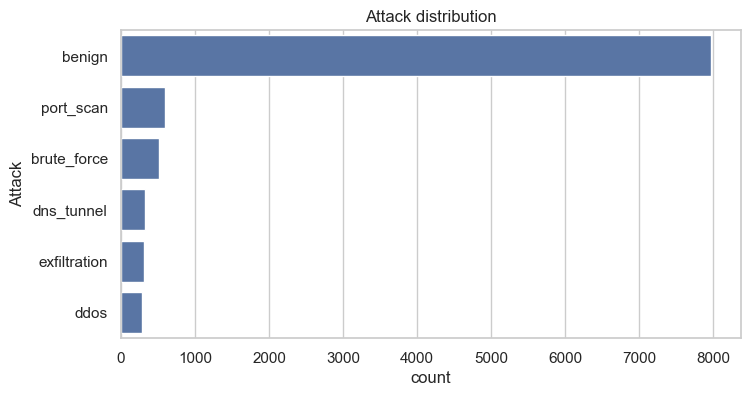

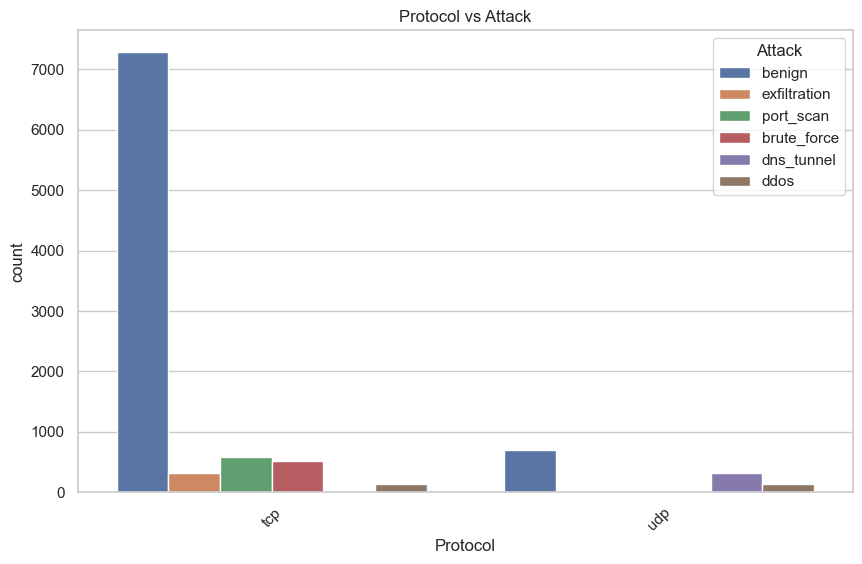

In [13]:

# Attack distribution and by Protocol
if 'Attack' in df.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(y='Attack', data=df, order=df['Attack'].value_counts().index)
    plt.title('Attack distribution')
    plt.show()

if set(['Protocol','Attack']).issubset(df.columns):
    plt.figure(figsize=(10,6))
    sns.countplot(x='Protocol', hue='Attack', data=df)
    plt.title('Protocol vs Attack')
    plt.xticks(rotation=45)
    plt.show()


## Cleaning examples

In [14]:

# Fill numeric with median, categorical with mode/ffill then bfill
df_clean = df.copy()
for c in num:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())

for c in df_clean.select_dtypes(exclude='number').columns:
    df_clean[c] = df_clean[c].fillna(method='ffill').fillna(method='bfill')
    if df_clean[c].isna().sum()>0:
        mode = df_clean[c].mode()
        if not mode.empty:
            df_clean[c] = df_clean[c].fillna(mode.iloc[0])
print('Missing after cleaning:', df_clean.isna().sum().sum())
df_clean.head()


Missing after cleaning: 0


,Date,Time,Source,Source_port,Destination,Dest_Port,Protocol,Service,Policy_ID,State,Action,Duration,Bytes,Packets,Attack,timestamp
0,2025-01-01,00:00:20,192.168.26.62,3106,140.23.152.109,27017,tcp,mongodb,POL-674,ESTABLISHED,allow,2.346,1074,2,benign,2025-01-01 00:00:20
1,2025-01-01,00:00:26,192.168.71.56,46777,2.195.207.41,27017,tcp,mongodb,POL-204,SYN_ACK,allow,0.299,689,1,benign,2025-01-01 00:00:26
2,2025-01-01,00:00:28,10.186.207.180,6188,32.250.237.97,110,tcp,pop3,POL-691,ESTABLISHED,allow,4.595,1651,1,benign,2025-01-01 00:00:28
3,2025-01-01,00:00:34,10.218.246.27,42684,26.98.72.117,80,tcp,http,POL-373,ESTABLISHED,allow,1.814,1106,3,benign,2025-01-01 00:00:34
4,2025-01-01,00:00:54,10.118.86.176,45890,164.177.143.57,6379,tcp,redis,POL-423,ESTABLISHED,allow,2.828,2054,7,benign,2025-01-01 00:00:54
